In [1]:
import subprocess
import tempfile
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
import random

### SET CWD TO REPO ROOT
os.chdir(Path.cwd().parent)
print("CWD now:", Path.cwd())

from rtl.py_lmul import lmul
from rtl.lmul_tester import BatchLMULTester

CWD now: /workspaces/LMUL-Hardware-Acceleration
✓ Batch tester ready


In [2]:
def float_to_bf16(f: float) -> int:
    """Convert float32 to bfloat16 (16-bit)"""
    if np.isnan(f):
        return 0x7FC0
    if np.isinf(f):
        return 0xFF80 if f < 0 else 0x7F80
    f = np.clip(f, -3.4e38, 3.4e38)
    f32_bits = struct.unpack('>I', struct.pack('>f', np.float32(f)))[0]
    bf16_bits = (f32_bits >> 16) & 0xFFFF
    return bf16_bits

def bf16_to_float(bf16: int) -> float:
    """Convert bfloat16 to float32"""
    f32_bits = (bf16 & 0xFFFF) << 16
    return struct.unpack('>f', struct.pack('>I', f32_bits))[0]

print("✓ BF16 utilities ready")



✓ BF16 utilities ready


In [3]:
class BatchLMULTester:
    """Test LMUL with batch operations in single simulation"""
    
    def __init__(self, verilog_file='rtl/top_lmul.v'):
        self.verilog_file = verilog_file
        
    def test_batch(self, test_pairs):
        """
        Test multiple multiplications in one simulation run
        
        Args:
            test_pairs: List of (a_bf16, b_bf16) tuples
            
        Returns:
            List of result_bf16 values
        """
        num_tests = len(test_pairs)
        
        # Generate test vectors
        test_vectors = ""
        for i, (a, b) in enumerate(test_pairs):
            test_vectors += f"        test_a[{i}] = 16'h{a:04x};\n"
            test_vectors += f"        test_b[{i}] = 16'h{b:04x};\n"
        
        testbench = f'''
        `timescale 1ns/1ps

        module tb;
            reg clk;
            reg rstn;
            reg i_valid;
            wire i_ready;
            reg [15:0] i_a;
            reg [15:0] i_b;
            wire o_valid;
            reg o_ready;
            wire [15:0] o_p;
            
            // Test vectors
            reg [15:0] test_a [0:{num_tests-1}];
            reg [15:0] test_b [0:{num_tests-1}];
            reg [15:0] results [0:{num_tests-1}];
            integer test_idx;
            integer result_idx;

            // Performance counters
            reg [63:0] cycle;
            reg [63:0] first_accept_cycle;
            reg [63:0] last_output_cycle;
            reg        started;
            
            // Instantiate DUT
            top_lmul dut (
                .clk(clk),
                .rstn(rstn),
                .i_valid(i_valid),
                .i_ready(i_ready),
                .i_a(i_a),
                .i_b(i_b),
                .o_valid(o_valid),
                .o_ready(o_ready),
                .o_p(o_p)
            );
            
            // Clock generation
            initial clk = 0;
            always #5 clk = ~clk;  // 10ns period (100 MHz nominal)

            // Global cycle counter with reset:
            // counts cycles from the moment reset is deasserted
            always @(posedge clk or negedge rstn) begin
                if (!rstn) begin
                    cycle <= 0;
                end else begin
                    cycle <= cycle + 1;
                end
            end
            
            // Capture outputs and track last output cycle
            always @(posedge clk) begin
                if (o_valid && o_ready) begin
                    results[result_idx] = o_p;
                    result_idx          = result_idx + 1;
                    last_output_cycle   = cycle;
                end
            end
            
            initial begin
                // Initialize test vectors
        {test_vectors}
                
                // Reset and init state
                rstn  = 0;
                i_valid = 0;
                i_a   = 0;
                i_b   = 0;
                o_ready = 1;  // Always ready to accept outputs
                test_idx  = 0;
                result_idx = 0;

                // Init perf counters
                cycle             = 0;
                first_accept_cycle = 0;
                last_output_cycle  = 0;
                started            = 0;
                
                // Apply reset (minimal but safe)
                repeat(2) @(posedge clk);
                rstn = 1;
                repeat(1) @(posedge clk);
                
                // Drive all test vectors
                for (test_idx = 0; test_idx < {num_tests}; test_idx = test_idx + 1) begin
                    // Wait for ready (0 cycles if DUT is always ready)
                    while (!i_ready) @(posedge clk);
                    
                    // Apply inputs and assert valid for one cycle
                    i_a     = test_a[test_idx];
                    i_b     = test_b[test_idx];
                    i_valid = 1;

                    // Record first accept cycle at first handshake
                    if (!started && i_ready) begin
                        started            = 1;
                        first_accept_cycle = cycle;
                    end
                    
                    // Advance one clock so DUT samples this transaction
                    @(posedge clk);

                    // Deassert valid before next transaction
                    i_valid = 0;
                end
                
                // Wait until all results are captured
                while (result_idx < {num_tests}) begin
                    @(posedge clk);
                end
                
                // Display results (hex outputs)
                for (test_idx = 0; test_idx < {num_tests}; test_idx = test_idx + 1) begin
                    $display("%04h", results[test_idx]);
                end

                // Display cycle window between first accepted input and last output
                $display("CYCLES_WINDOW=%0d", last_output_cycle - first_accept_cycle + 1);

                // Display total cycles since reset deassertion (overall runtime in cycles)
                $display("TOTAL_CYCLES=%0d", cycle);
                
                $finish;
            end
            
            // Timeout guard (very generous, but only used if DUT hangs)
            initial begin
                #{200000 + num_tests * 1000};
                $display("ERROR: Timeout");
                $finish;
            end
        endmodule
        '''

        
        # Write testbench
        with tempfile.NamedTemporaryFile(mode='w', suffix='.v', delete=False) as f:
            tb_file = f.name
            f.write(testbench)
        
        try:
            # Compile
            rtl_dir = os.path.abspath('rtl')
            top_file = os.path.join(rtl_dir, 'top_lmul.v')
            lmul_file = os.path.join(rtl_dir, 'lmul_bf16.v')
            out_file = '/tmp/lmul_batch_sim.out'
            
            compile_result = subprocess.run(
                ['iverilog', '-o', out_file, '-g2012',
                 top_file, lmul_file, tb_file],
                capture_output=True,
                text=True
            )
            
            if compile_result.returncode != 0:
                raise RuntimeError(f"Compilation failed:\n{compile_result.stderr}")
            
            # Run simulation
            # time this section
            start = end = sim_result = None

            start = time.time()
            sim_result = subprocess.run(
                ['vvp', out_file],
                capture_output=True,
                text=True,
                timeout=10
            )
            end = time.time()

            # print(sim_result.stdout)
                            
            lines = sim_result.stdout.strip().split('\n')
            results = []
            cycles_window = None
            total_cycles = None

            for line in lines:
                if line.startswith("ERROR"):
                    raise RuntimeError(f"Simulation error: {line}")
                if line.startswith("CYCLES_WINDOW="):
                    cycles_window = int(line.split("=", 1)[1])
                    continue
                if line.startswith("TOTAL_CYCLES="):
                    total_cycles = int(line.split("=", 1)[1])
                    continue
                try:
                    results.append(int(line, 16))
                except ValueError:
                    continue

            return results, end - start, cycles_window, total_cycles
            
        finally:
            # Cleanup
            if os.path.exists(tb_file):
                os.remove(tb_file)
            if os.path.exists(out_file):
                os.remove(out_file)

batch_tester = BatchLMULTester()
print("✓ Batch tester ready")

✓ Batch tester ready


In [4]:
# Generate test data
N = 100_000
np.random.seed(42)
test_data = []
for i in range(N):
    a_float = np.random.uniform(-10, 10)
    b_float = np.random.uniform(-10, 10)
    a_bf16 = float_to_bf16(a_float)
    b_bf16 = float_to_bf16(b_float)
    test_data.append((a_bf16, b_bf16, a_float, b_float))

print("✓ Test data generated")

✓ Test data generated


In [5]:
# Benchmark 1: LMUL Hardware (batch mode)
print("1. LMUL Hardware (batch simulation):")
SIMULATION_CLOCK_HZ = 100_000_000  # 100 MHz
test_pairs = [(a_bf16, b_bf16) for a_bf16, b_bf16, _, _ in test_data]

hw_results_bf16, hw_time, cycles_window, total_cycles = batch_tester.test_batch(test_pairs)

hw_cycles_per_op = cycles_window / N
hw_latency_per_op = hw_cycles_per_op / SIMULATION_CLOCK_HZ  # seconds
hw_total_latency = cycles_window / SIMULATION_CLOCK_HZ  # seconds
hw_throughput = SIMULATION_CLOCK_HZ / hw_cycles_per_op  # ops/sec

print(f"   Total time: {hw_time:.3f}s")
print(f"   Total cycles: {cycles_window}")
print(f"   Cycles per op: {hw_cycles_per_op:.2f} cycles/op")
print(f"   Theoretical latency: {hw_total_latency:.6f}s")
print(f"   Theoretical latency per op: {hw_latency_per_op*1e6:.2f}μs")
print(f"   Theoretical throughput: {hw_throughput:.0f} ops/sec")

1. LMUL Hardware (batch simulation):
   Total time: 0.828s
   Total cycles: 100001
   Cycles per op: 1.00 cycles/op
   Theoretical latency: 0.001000s
   Theoretical latency per op: 0.01μs
   Theoretical throughput: 99999000 ops/sec


In [6]:
# Benchmark 2: Python float32
print("\n2. Python float32 multiplication:")
start = time.time()
py_results = []
for _, _, a_float, b_float in test_data:
    result = a_float * b_float
    py_results.append(result)
py_time = time.time() - start
py_per_op = py_time / N

print(f"   Total time: {py_time:.6f}s")
print(f"   Per operation: {py_per_op*1e6:.2f}μs")
print(f"   Throughput: {N/py_time:.0f} ops/sec")


2. Python float32 multiplication:
   Total time: 0.084282s
   Per operation: 0.84μs
   Throughput: 1186491 ops/sec


In [7]:
# Benchmark 3: NumPy vectorized
print("\n3. NumPy vectorized multiplication:")
a_array = np.array([d[2] for d in test_data], dtype=np.float32)
b_array = np.array([d[3] for d in test_data], dtype=np.float32)

start = time.time()
np_results = a_array * b_array
np_time = time.time() - start
np_per_op = np_time / N

print(f"   Total time: {np_time:.6f}s")
print(f"   Per operation: {np_per_op*1e6:.2f}μs")
print(f"   Throughput: {N/np_time:.0f} ops/sec")


3. NumPy vectorized multiplication:
   Total time: 0.000372s
   Per operation: 0.00μs
   Throughput: 268521383 ops/sec


In [8]:
# Benchmark 4: Python float32
print("\n2. Python LMUL:")
start = time.time()
pylmul_results = []
for a_float, b_float, _, _ in test_data:
    result = lmul(a_float, b_float)
    pylmul_results.append(result)
pylmul_time = time.time() - start
py_per_op = py_time / N

print(f"   Total time: {pylmul_time:.6f}s")
print(f"   Per operation: {py_per_op*1e6:.2f}μs")
print(f"   Throughput: {N/pylmul_time:.0f} ops/sec")


2. Python LMUL:
   Total time: 0.091802s
   Per operation: 0.84μs
   Throughput: 1089305 ops/sec


In [9]:
# Summary
print("\n" + "-" * 60)
print("SPEED COMPARISON:")
print("-" * 60)
print(f"Python FP32:         1.00x (baseline)")
print(f"NumPy vectorized:    {py_time/np_time:.2f}x faster")
print(f"LMUL batch sim:      {py_time/hw_total_latency:.2f}x vs Python")
print(f"                     ({np_time/hw_total_latency:.2f}x vs NumPy)")
print(f"Python LMUL:         {py_time/pylmul_time:.2f}x vs Python")



------------------------------------------------------------
SPEED COMPARISON:
------------------------------------------------------------
Python FP32:         1.00x (baseline)
NumPy vectorized:    226.32x faster
LMUL batch sim:      84.28x vs Python
                     (0.37x vs NumPy)
Python LMUL:         0.92x vs Python


In [10]:
test_sizes = np.array([10 ** i for i in range(1, 6)])
py_times = []
np_times = []
lmul_times = []
pylmul_times = []

for size in test_sizes:
    # Generate random test data
    test_data = []
    for _ in range(size):
        a_float = np.random.uniform(-10, 10)
        b_float = np.random.uniform(-10, 10)
        a_bf16 = float_to_bf16(a_float)
        b_bf16 = float_to_bf16(b_float)
        test_data.append((a_bf16, b_bf16, a_float, b_float))

    # Benchmark Python float32
    start = time.time()
    py_results = [a_float * b_float for _, _, a_float, b_float in test_data]
    py_times.append(time.time() - start)

    # Benchmark NumPy vectorized
    a_array = np.array([d[2] for d in test_data], dtype=np.float32)
    b_array = np.array([d[3] for d in test_data], dtype=np.float32)
    start = time.time()
    np_results = a_array * b_array
    np_times.append(time.time() - start)

    # Benchmark LMUL Hardware (batch mode)
    test_pairs = [(a_bf16, b_bf16) for a_bf16, b_bf16, _, _ in test_data]
    _, _, _, total_cycles = batch_tester.test_batch(test_pairs)
    lmul_times.append(total_cycles / SIMULATION_CLOCK_HZ)

    # Benchmark Python LMUL
    start = time.time()
    pylmul_results = [lmul(a_float, b_float) for a_float, b_float, _, _ in test_data]
    pylmul_times.append(time.time() - start)

In [11]:
py_op_times = np.array(py_times) / test_sizes
np_op_times = np.array(np_times) / test_sizes
lmul_op_times = np.array(lmul_times) / test_sizes
pylmul_op_times = np.array(pylmul_times) / test_sizes

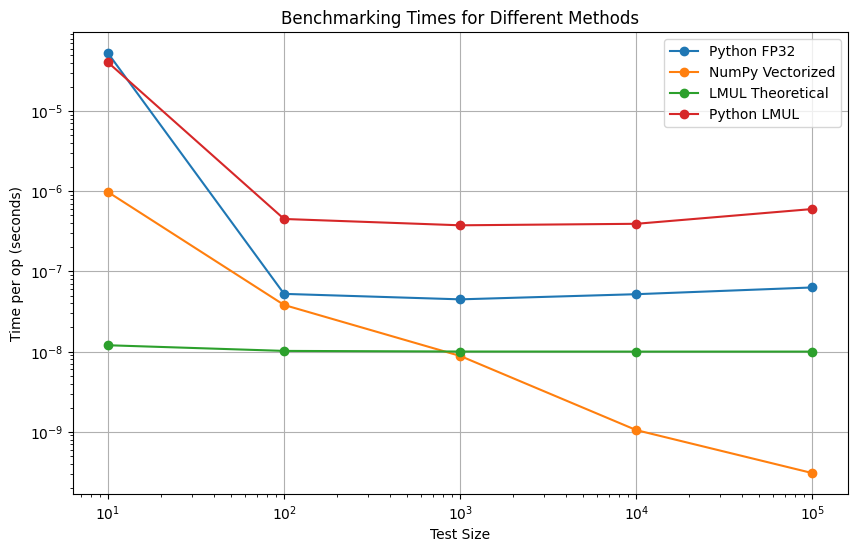

In [12]:
plt.figure(figsize=(10, 6))

plt.xscale('log')
plt.yscale('log')

plt.plot(test_sizes, py_op_times, label='Python FP32', marker='o')
plt.plot(test_sizes, np_op_times, label='NumPy Vectorized', marker='o')
plt.plot(test_sizes, lmul_op_times, label='LMUL Theoretical', marker='o')
plt.plot(test_sizes, pylmul_op_times, label='Python LMUL', marker='o')

plt.xlabel('Test Size')
plt.ylabel('Time per op (seconds)')
plt.title('Benchmarking Times for Different Methods')
plt.legend()
plt.grid(True)
plt.show()
